In [1]:
# Pick up package from parent folder
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import sklearn
from sklearn import metrics
import time

import gensim.downloader as model_api

import ordinal
from ordinal import OrderedProbitRanker
from ordinal import OrderedLogitRanker

import AppReviews # generate review data from app store
import docembedding

In [3]:
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=300, random_state=42)
X, y = shuffle(X, y, random_state=7)
X = StandardScaler().fit_transform(X)

opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
opr.fit(X, y)

ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])
betas = np.concatenate([opr.cuts_, opr.coef_])

print(opr._ordered_probit_loss_and_grad(betas, ymasks, X))
print(opr._orderedProbitLogLike(betas, ymasks, X))
print(betas)
print(opr.score(X, y))

(2.4724253858878653e-06, array([-9.27701658e-07, -6.72218822e-06, -8.76166511e-06, -4.40861584e-06]))
1565.0433755322442
[-18.39984029  16.20564413   3.27508509 -26.71431485]
1.0


In [4]:
n_samples = ymasks.shape[1]
n_cuts = ymasks.shape[0] - 1
# TODO: xb can "explode" out of normal cdf bounds
#       eg. values above 8 and below -8 have cdf of 0 and 1 
#       regardless of cutoff point
xb = X @ betas[n_cuts:]
# ensure cutpoints remain ordered
# TODO: This can be done by reparametrizing the cutpoints...
cuts = np.sort(betas[:n_cuts])
# cdf up to cutpoints
cdf_areas = [norm.cdf(ct - xb) for ct in cuts]
# last cdf area is from last cutpoint on
cdf_areas.append(cdf_areas[-1])
cdf_areas = np.array(cdf_areas)
# pdf areas between cutpoints = cdf[i] - cdf[i-1]
pdf_areas = np.empty_like(ymasks, dtype='float')
# first is cdf[cut_0] - 0
pdf_areas[0] = cdf_areas[0]
# last is 1 - cdf[last_cut]
pdf_areas[-1] = 1 - cdf_areas[-1]
# middle cuts are cdf area between each
for i in range(1, n_cuts):
    pdf_areas[i] = cdf_areas[i] - cdf_areas[i-1]
res = np.zeros(n_samples)
for i in range(len(ymasks)):
    res += (ymasks[i] * pdf_areas[i])
res = np.sum(np.log(res))
res

-2.4724253858878653e-06

In [5]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud
from sklearn.preprocessing import KBinsDiscretizer

N_CLASSES = 6

boston = load_boston()
X = boston['data']
y = boston['target']
kbd = KBinsDiscretizer(n_bins=N_CLASSES, encode='ordinal', strategy='kmeans')
y = kbd.fit_transform(y.reshape(-1, 1)).flatten().astype(np.int32)

opr = OrderedProbitRanker(method='nelder-mead', use_grad=False)
opr.fit(X, y)

ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])
betas = np.concatenate([opr.cuts_, opr.coef_])

print(opr._ordered_probit_loss_and_grad(betas, ymasks, X))
print(opr._orderedProbitLogLike(betas, ymasks, X))
print(betas)
print(opr.score(X, y))

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:518: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
E:\Ordinal-master\ordinal\probit.py:243: OptimizeWarning: Unknown solver options: maxfun
  options={"disp":self.verbose, 'maxiter':50000, "maxfun":150000})


(575.8093376841421, array([ 2.17592149e+01, -9.23870343e-01,  3.02404087e-01,  1.97137120e-01,
       -8.41257406e+01, -3.57810154e+04,  4.01308808e+03, -3.84396881e+04,
        1.36201202e+01, -1.14359534e+03, -1.31169330e+04, -2.31754534e+05,
       -9.69266174e+02, -5.64944669e+04, -1.45403021e+06, -3.76034254e+04,
       -1.88931125e+05, -3.33024710e+04]))
inf
[ 5.81636586e-02  1.54150895e+00  2.89921339e+00  3.54314359e+00
  4.20362514e+00 -2.62811094e-02  7.51365116e-03 -1.71419206e-02
  7.28142327e-02 -5.61142824e-02  3.36518497e-02  1.45994030e-02
  4.83031094e-02  3.56216073e-02 -7.11355698e-04 -7.59703143e-03
  7.33084206e-03 -1.71157425e-01]
0.525691699604743


E:\Ordinal-master\ordinal\probit.py:109: RuntimeWarning: divide by zero encountered in log
  res = np.sum(np.log(res))


In [6]:
n_samples = ymasks.shape[1]
n_cuts = ymasks.shape[0] - 1
# TODO: xb can "explode" out of normal cdf bounds
#       eg. values above 8 and below -8 have cdf of 0 and 1 
#       regardless of cutoff point
xb = X @ betas[n_cuts:]
# ensure cutpoints remain ordered
# TODO: This can be done by reparametrizing the cutpoints...
cuts = np.sort(betas[:n_cuts])
# cdf up to cutpoints
cdf_areas = [norm.cdf(ct - xb) for ct in cuts]
# last cdf area is from last cutpoint on
cdf_areas.append(cdf_areas[-1])
cdf_areas = np.array(cdf_areas)
# pdf areas between cutpoints = cdf[i] - cdf[i-1]
pdf_areas = np.empty_like(ymasks, dtype='float')
# first is cdf[cut_0] - 0
pdf_areas[0] = cdf_areas[0]
# last is 1 - cdf[last_cut]
pdf_areas[-1] = 1 - cdf_areas[-1]
# middle cuts are cdf area between each
for i in range(1, n_cuts):
    pdf_areas[i] = cdf_areas[i] - cdf_areas[i-1]
res = np.zeros(n_samples)
for i in range(len(ymasks)):
    res += (ymasks[i] * pdf_areas[i])
res = np.sum(np.log(res))
res

-575.8093376841421

In [7]:
raise ValueError()

ValueError: 

In [ ]:
dft = pd.read_csv("cache.csv")
X = dft.drop('rating', 1)
y = dft.rating

opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
opr.fit(X, y)

ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])
betas = np.concatenate([opr.cuts_, opr.coef_])

print(opr._ordered_probit_loss_and_grad(betas, ymasks, X))
print(opr._orderedProbitLogLike(betas, ymasks, X))
print(opr.score(X, y))

In [ ]:
raise ValueError()

# Training prepro

In [8]:
df = pd.read_csv("app_reviews.csv")
df.rating = df.rating.astype(int)
df.head(5)

,app_name,title,version,rating,review,vote_count
0,Tomb of the Mask,Overall fun game...but,1.6,2,ENOUGH of the ads. I know the creator wants to...,0.0
1,Tomb of the Mask,Would be good if not for the ads,1.6,1,"Everything you do requires an ad, it’s really ...",0.0
2,Tomb of the Mask,AMAZING,1.6,5,This game is so indicting and I love it,0.0
3,Tomb of the Mask,So many ads,1.6,4,The game itself is really fun but you go throu...,0.0
4,Tomb of the Mask,Terrible app,1.6,1,This app has a cool game in it. However the ap...,0.0


In [9]:
model = model_api.load("glove-wiki-gigaword-300")

dft = df.join(pd.get_dummies(df.app_name, drop_first=True, dummy_na=True))

# Add embedding components
for col in ['title', 'review']:
    tokens = docembedding.stringprocessing.tokenize(dft[col], lower=True, split=True)
    weights = docembedding.embedding.getWordWeights(tokens, "tf-idf")
    embeds = docembedding.embedding.sentenceEmbedding(tokens, model, weights)
    embeds = pd.DataFrame(embeds)
    embeds.columns = [col + str(colnum) for colnum in embeds.columns]
    dft = dft.join(embeds)
dft = dft.drop(['version', 'vote_count', 'review', 'title', 'app_name'], 1)
dft.head(3)

E:\Ordinal-master\examples\docembedding\embedding.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sentenceWords = sentenceWords[[notOOVindices]]
E:\Ordinal-master\examples\docembedding\embedding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wordWeights = wordWeights[[notOOVindices]]


,rating,Google Maps - GPS Navigation,Google Maps - Transit & Food,Hello Stars,Messenger,Tomb of the Mask,Ultra Sharp,nan,title0,title1,...,review290,review291,review292,review293,review294,review295,review296,review297,review298,review299
0,2,0,0,0,0,1,0,0,0.008337,0.359944,...,0.011253,-0.144465,-0.039978,0.146787,0.108508,-0.151146,0.080810,-0.069745,-0.002517,-0.003518
1,1,0,0,0,0,1,0,0,-0.146053,0.298234,...,0.024687,-0.224383,-0.130395,0.051382,0.121735,0.026025,0.077560,-0.115350,0.008827,-0.006115
2,5,0,0,0,0,1,0,0,0.149990,0.053597,...,-0.153915,-0.110484,-0.303880,0.008504,0.138842,-0.395003,0.191106,-0.088626,0.061870,0.016231


In [10]:
X = dft.drop('rating', 1)
y = dft.rating

In [11]:
def fitscore(model, X, y):
    start = time.time()
    model.fit(X, y)
    pred_val = model.predict(X)
    print("time: ", time.time() - start)
    print("score: ", metrics.accuracy_score(pred_val, y))
    print("mse: ", metrics.mean_squared_error(pred_val, y))
    print("mae: ", metrics.mean_absolute_error(pred_val, y))
    pd.Series(pred_val).hist(bins=5)

In [12]:
y.hist(bins=5)

time:  13.834228515625
score:  0.6763732065540369
mse:  1.4724509720689363
mae:  0.6029374310213091


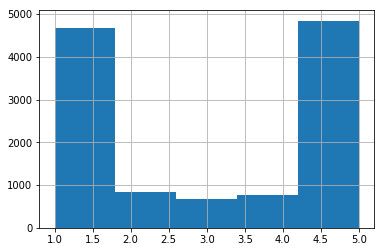

In [13]:
lr = sklearn.linear_model.LogisticRegression(C=9999, solver='lbfgs', multi_class='auto', max_iter=10000)
fitscore(lr, X, y)

time:  6.647398948669434
score:  0.5492826216147381
mse:  1.2074879021988285
mae:  0.6604125986925885


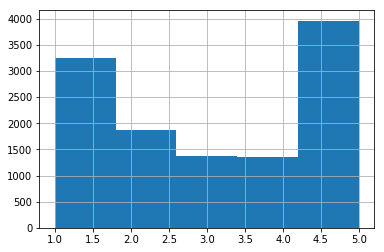

In [14]:
lat = OrderedLogitRanker(alpha=1, verbose=1, variant='at')
fitscore(lat, X, y)

time:  4.512451887130737
score:  0.6111724255030139
mse:  2.1597758723151372
mae:  0.809576364716869


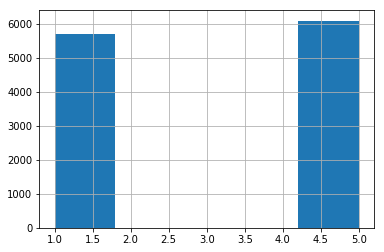

In [15]:
lit = OrderedLogitRanker(alpha=1, verbose=1, variant='it')
fitscore(lit, X, y)

time:  7.55546236038208
score:  0.45148145003820356
mse:  1.1612191187706935
mae:  0.7313014687155106


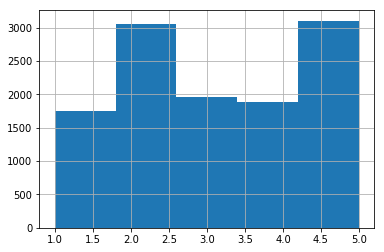

In [16]:
lse = OrderedLogitRanker(alpha=1, verbose=1,  variant='se')
fitscore(lse, X, y)

E:\Ordinal-master\ordinal\probit.py:251: RuntimeWarning: 
Ordered Probit Optimization did not succeed
Termination Status: 1
Termination Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
function Value:12309.140709981799
Iterations:217
  RuntimeWarning)


time:  685.8382048606873
score:  0.6139740215638
mse:  2.057220477120299
mae:  0.7839375159181594


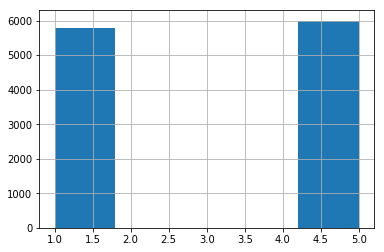

In [17]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
fitscore(opr, X, y)

# TESTING

In [18]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
start = time.time()
opr.fit(X, y)
print("time: ", time.time() - start)
print("score: ", opr.score(X, y))
print("cuts: ", opr.cuts_)

E:\Ordinal-master\ordinal\probit.py:251: RuntimeWarning: 
Ordered Probit Optimization did not succeed
Termination Status: 1
Termination Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
function Value:12309.140709981799
Iterations:217
  RuntimeWarning)


time:  703.3344194889069
score:  0.6139740215638
cuts:  [-0.72254795 -0.20671248  0.25971425  0.81529927]


In [ ]:
n_cuts = len(opr.cuts_)
n_samples = len(X)
betas = opr.coef_

xb = X @ opr.coef_
ymasks = np.array([np.array(y == c_) for c_ in opr.classes_])
cdf_areas = [norm.cdf(ct - xb) for ct in opr.cuts_]
cdf_areas.append(cdf_areas[-1])
cdf_areas = np.array(cdf_areas)
pdf_areas = np.zeros_like(ymasks, dtype='float')
pdf_areas[0] = cdf_areas[0]
pdf_areas[-1] = 1 - cdf_areas[-1]
for i in range(1, n_cuts):
    pdf_areas[i] = cdf_areas[i] - cdf_areas[i-1]
res = np.zeros(n_samples)
for i in range(len(ymasks)):
    res += (ymasks[i] * pdf_areas[i])

In [ ]:
out = pd.Series(res)
ymk = pd.DataFrame(ymasks.T)
pdf = pd.DataFrame(pdf_areas.T)
cdf = pd.DataFrame(cdf_areas.T)
bad = (out == 0)